In [11]:
import comparison as cmp
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc_spc
TWOPI = cmp.TWOPI

In [12]:
!ls MD_DATA

data_a10_n06.npz  data_a10_n10.npz  data_a10_n14.npz
data_a10_n08.npz  data_a10_n12.npz  data_a10_n16.npz


In [13]:
!pwd

/home/michele/contact_line_model


In [14]:
# Some useful definitions...
cos = lambda t : np.cos( np.deg2rad(t) )
sin = lambda t : np.sin( np.deg2rad(t) )
tan = lambda t : np.tan( np.deg2rad(t) )
cot = lambda t : 1.0/np.tan( np.deg2rad(t) )
tan_m1 = lambda t : np.rad2deg(np.arctan(t))
cos_m1 = lambda t : np.rad2deg(np.arccos(t))
sin_m1 = lambda t : np.rad2deg(np.arcsin(t))

In [15]:
# Load MD simulation output
n_tags = ['06','08','10','12','14','16']
n_range = [6,8,10,12,14,16]
md_output = dict()
for nt in n_tags :
    md_output[nt] = np.load("MD_DATA/data_a10_n"+nt+".npz")

In [16]:
# Number of replicates for the Langevin model
m_rep = 50
# Time-step for the EM method
t_bin_em = 0.1

In [17]:
# Reference substrate
n_sub = 16
n_sub_tag = str(n_sub).zfill(2)
a_sub = 1
a_sub_tag = str(a_sub).zfill(2)

In [18]:
# Loading MD data
t_md = md_output[n_sub_tag]['t']
theta_avg_md = md_output[n_sub_tag]['theta']
x_avg_md = md_output[n_sub_tag]['x']
theta_std_md = md_output[n_sub_tag]['theta_std']
x_std_md = md_output[n_sub_tag]['x_std']

In [19]:
""" Parameters of the Langevin model """

# From other simulations and system preparation...
R0_drop = 15
etaw = 0.69
theta_e_md = 55.6
Lx_sub = 20.7
l_sub = Lx_sub/n_sub
muf_md = 5.659896689453016
t_fin_md = t_md[-1]

# Initial conditions
a2 = a_sub**2
rough_parameter = (2.0/np.pi) * np.sqrt(a2+1.0) * sc_spc.ellipe(a2/(a2+1.0))
print("r =",rough_parameter)
theta_g_0 = theta_avg_md[0]
theta_g_0_flat_in = cos_m1(cos(theta_g_0)/rough_parameter)
print("theta_g_0_flat_in =",theta_g_0_flat_in)

r = 1.2160067234249798
theta_g_0_flat_in = 101.19470548908104


In [20]:
""" Finding optimal noise (ugly) """

# Upper and lower bounds for the amout of thermal noise (guessed?)
Mscan = 125
# noise_range = np.linspace(0.00,3.0,Mscan)
noise_range = np.geomspace(0.01,5.0,num=Mscan-1)
noise_range = np.insert(noise_range,0,0.0)
err_range_xcl = np.zeros(Mscan)
err_range_theta = np.zeros(Mscan)

In [21]:
### Error on contact line position and contact angle ###
### This could be accelerated with MPI! ###

for i in range(len(noise_range)) :
    
    print(">>> Simulation",(i+1),"/",Mscan)
    print(">>> Noise (nondim.),",noise_range[i])
    
    RS = cmp.RoughSubstrate(l=l_sub,mu_f=muf_md,R0=R0_drop,a=a_sub,theta_g_0_flat=theta_g_0_flat_in,
                            theta_e=theta_e_md,Gamma=noise_range[i])

    EM = cmp.EulerMurayama(RS=RS,t_fin=t_fin_md,t_bin=t_bin_em,M=m_rep)
    EM.simulate_ode(RS)
    EM.simulate_sde(RS)

    theta_w = RS.theta_w
    theta_fin_ode = EM.theta_g_vec[-1]
    theta_fin_sde = np.mean(EM.theta_g_ens[int(0.8*EM.Nt):])

    t_lang = RS.tau*EM.t_vec
    x_lang = TWOPI*EM.x_ens/RS.k
    x_lang_int = np.interp(t_md, t_lang, x_lang)
    theta_lang = EM.theta_g_ens
    theta_lang_int = np.interp(t_md, t_lang, theta_lang)

    err_xcl = np.sqrt((np.sum(x_avg_md-x_lang_int)**2))/(R0_drop*len(x_lang_int))
    err_theta = np.sqrt((np.sum(theta_avg_md-theta_lang_int)**2))/(theta_e_md*len(theta_lang_int))
    err_range_xcl[i] = err_xcl
    err_range_theta[i] = err_theta
    print(">>> Error on xcl (nondim.):",err_xcl)
    print(">>> Error on theta (nondim.):",err_theta)
    print("-----------------------------------------------------------------")

>>> Simulation 1 / 125
>>> Noise (nondim.), 0.0
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.0 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates


/home/michele/contact_line_model/comparison.py:218: RuntimeWarning: invalid value encountered in sqrt
  self.x_std = np.sqrt(self.x_var)
/home/michele/contact_line_model/comparison.py:223: RuntimeWarning: invalid value encountered in sqrt
  self.theta_std = np.sqrt(self.theta_var)


>>> Error on xcl (nondim.): 0.5986312697827354
>>> Error on theta (nondim.): 0.6625471586628761
-----------------------------------------------------------------
>>> Simulation 2 / 125
>>> Noise (nondim.), 0.01
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.01 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.5431707508400428
>>> Error on the

>>> Error on xcl (nondim.): 0.5160241006135243
>>> Error on theta (nondim.): 0.5656277482550837
-----------------------------------------------------------------
>>> Simulation 11 / 125
>>> Noise (nondim.), 0.015757438111353553
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.015757438111353553 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.

>>> Error on xcl (nondim.): 0.48875516301896027
>>> Error on theta (nondim.): 0.5346349693793473
-----------------------------------------------------------------
>>> Simulation 20 / 125
>>> Noise (nondim.), 0.024829685583313735
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.024829685583313735 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0

>>> Error on xcl (nondim.): 0.4290091957921146
>>> Error on theta (nondim.): 0.46739703118607406
-----------------------------------------------------------------
>>> Simulation 29 / 125
>>> Noise (nondim.), 0.039125223390343376
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.039125223390343376 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0

>>> Error on xcl (nondim.): 0.3617084661804439
>>> Error on theta (nondim.): 0.3945937313952987
-----------------------------------------------------------------
>>> Simulation 38 / 125
>>> Noise (nondim.), 0.061651328616621794
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.061651328616621794 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.

>>> Error on xcl (nondim.): 0.2644986067989334
>>> Error on theta (nondim.): 0.2953353827061664
-----------------------------------------------------------------
>>> Simulation 47 / 125
>>> Noise (nondim.), 0.09714669951591383
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.09714669951591383 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.25

>>> Error on xcl (nondim.): 0.15713829831766174
>>> Error on theta (nondim.): 0.19350773688030473
-----------------------------------------------------------------
>>> Simulation 56 / 125
>>> Noise (nondim.), 0.15307831053442725
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.15307831053442725 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.

>>> Error on xcl (nondim.): 0.02669574351316673
>>> Error on theta (nondim.): 0.07899723310682251
-----------------------------------------------------------------
>>> Simulation 65 / 125
>>> Noise (nondim.), 0.24121220044367983
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.24121220044367983 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.

>>> Error on xcl (nondim.): 0.02262302597758823
>>> Error on theta (nondim.): 0.04175750238304678
-----------------------------------------------------------------
>>> Simulation 74 / 125
>>> Noise (nondim.), 0.38008863201946913
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.38008863201946913 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.

>>> Error on xcl (nondim.): 0.07997604324219786
>>> Error on theta (nondim.): 0.00019938429811985317
-----------------------------------------------------------------
>>> Simulation 83 / 125
>>> Noise (nondim.), 0.598922309587582
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.598922309587582 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.0

>>> Error on xcl (nondim.): 0.06483304065080592
>>> Error on theta (nondim.): 0.016192551206542942
-----------------------------------------------------------------
>>> Simulation 92 / 125
>>> Noise (nondim.), 0.9437481226835257
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.9437481226835257 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.0

>>> Error on xcl (nondim.): 0.13449583173430832
>>> Error on theta (nondim.): 0.025623045303815855
-----------------------------------------------------------------
>>> Simulation 101 / 125
>>> Noise (nondim.), 1.487105263589175
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 1.487105263589175 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.11

>>> Error on xcl (nondim.): 0.11588349513468657
>>> Error on theta (nondim.): 0.009218253776329531
-----------------------------------------------------------------
>>> Simulation 110 / 125
>>> Noise (nondim.), 2.3432969156074543
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 2.3432969156074543 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.

>>> Error on xcl (nondim.): 0.14555834845984303
>>> Error on theta (nondim.): 0.001997494394391181
-----------------------------------------------------------------
>>> Simulation 119 / 125
>>> Noise (nondim.), 3.692435612421013
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 3.692435612421013 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates
>>> Error on xcl (nondim.): 0.21

<IPython.core.display.Javascript object>


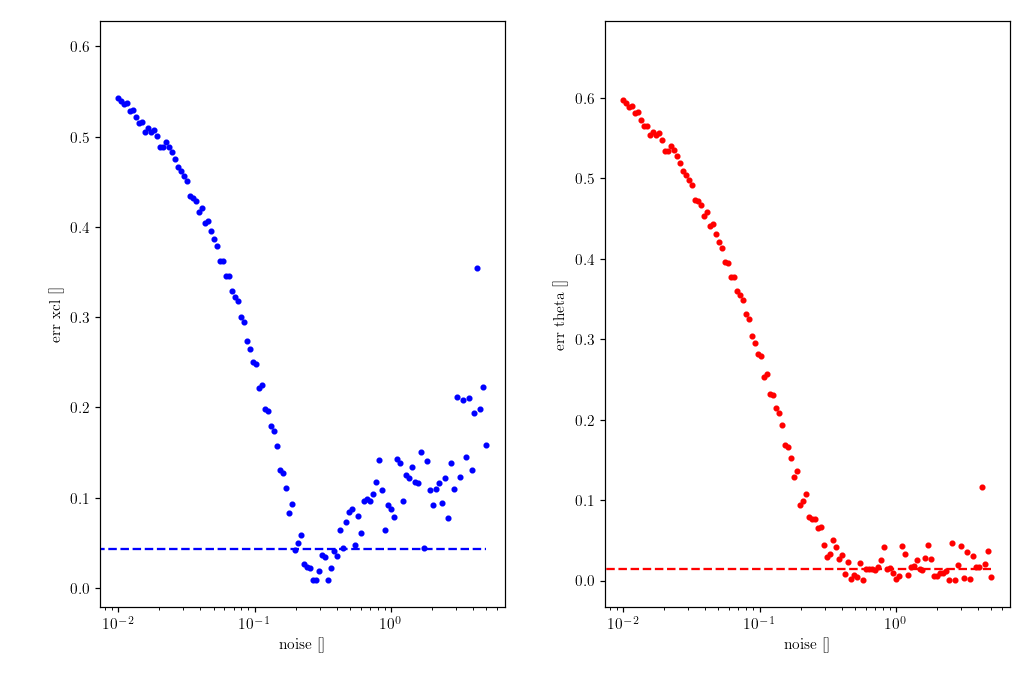

In [22]:
%matplotlib notebook

fig1, (ax1, ax2) = plt.subplots(1, 2)

ref_err_xcl = np.mean(x_std_md)/(5*R0_drop)
ref_err_theta = np.mean(theta_std_md)/(5*theta_e_md)

ax1.semilogx(noise_range, err_range_xcl, 'b.')
ax1.semilogx([noise_range[0],noise_range[-1]],[ref_err_xcl,ref_err_xcl],
        'b--')
ax1.set_xlabel('noise []')
ax1.set_ylabel('err xcl []')

ax2.semilogx(noise_range, err_range_theta, 'r.')
ax2.semilogx([noise_range[0],noise_range[-1]],[ref_err_theta,ref_err_theta],
        'r--')
ax2.set_xlabel('noise []')
ax2.set_ylabel('err theta []')

plt.tight_layout()

In [24]:
# Found by "visual inspection"
noise_opt = 0.5*(0.25+0.42)
RS = cmp.RoughSubstrate(l=l_sub,mu_f=muf_md,R0=R0_drop,a=a_sub,theta_g_0_flat=theta_g_0_flat_in,
                        theta_e=theta_e_md,Gamma=noise_opt)

EM = cmp.EulerMurayama(RS=RS,t_fin=t_fin_md,t_bin=t_bin_em,M=m_rep)
EM.simulate_ode(RS)
EM.simulate_sde(RS)

theta_w = RS.theta_w
theta_fin_ode = EM.theta_g_vec[-1]
theta_fin_sde = np.mean(EM.theta_g_ens[int(0.8*EM.Nt):])

C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.33499999999999996 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 50
Simulating 50 replicates


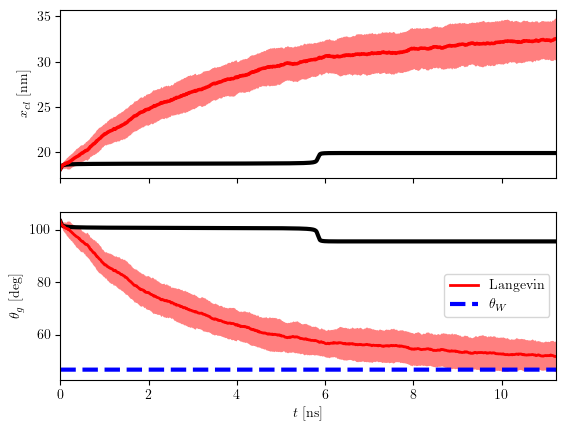

In [25]:
%matplotlib inline

fig1, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(RS.tau*EM.t_vec, TWOPI*EM.x_vec/RS.k, 'k-', linewidth=3.0)
ax1.plot(RS.tau*EM.t_vec, TWOPI*EM.x_ens/RS.k, 'r-', linewidth=2.5)
ax1.fill_between(RS.tau*EM.t_vec,TWOPI*(EM.x_ens+EM.x_std)/RS.k,TWOPI*(EM.x_ens-EM.x_std)/RS.k,
                 color='r',alpha=0.5,linewidth=0.0)
ax1.set_ylabel(r'$x_{cl}$ [nm]')#, fontsize=30.0)
ax1.set_xlim([RS.tau*EM.t_vec[0], RS.tau*EM.t_vec[-1]])
ax1.tick_params(axis='x',which='both',labelbottom=False)
ax1.tick_params(axis='y')#, labelsize=25)

ax2.plot(RS.tau*EM.t_vec, EM.theta_g_vec, 'k-', linewidth=3.0)
ax2.plot(RS.tau*EM.t_vec, EM.theta_g_ens, 'r-', linewidth=2.0, label='Langevin')
ax2.fill_between(RS.tau*EM.t_vec,EM.theta_g_ens+EM.theta_std,EM.theta_g_ens-EM.theta_std,
                 color='r',alpha=0.5,linewidth=0.0)
ax2.plot(RS.tau*EM.t_vec, RS.theta_w*np.ones(EM.t_vec.shape), 'b--', linewidth=3, label=r'$\theta_W$')
ax2.set_xlabel(r'$t$ [ns]')#, fontsize=30.0)
ax2.set_ylabel(r'$\theta_g$ [deg]')#, fontsize=30.0)
ax2.set_xlim([RS.tau*EM.t_vec[0], RS.tau*EM.t_vec[-1]])
ax2.legend()#fontsize=25)
ax2.tick_params(axis='x')#, labelsize=25)
ax2.tick_params(axis='y')#, labelsize=25)

plt.show()

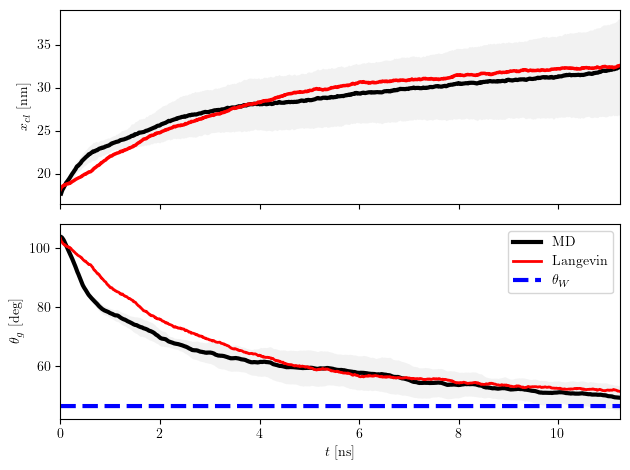

In [26]:
%matplotlib inline

"""
t_md = md_output['16']['t']
theta_avg_md = md_output['16']['theta']
x_avg_md = md_output['16']['x']
theta_std_md = md_output['16']['theta_std']
x_std_md = md_output['16']['x_std']
"""

fig1, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t_md, x_avg_md, 'k-', linewidth=3.0)
ax1.fill_between(t_md,x_avg_md-x_std_md,x_avg_md+x_std_md,color='0.9',alpha=0.5,linewidth=0.0)

ax1.plot(RS.tau*EM.t_vec, TWOPI*EM.x_ens/RS.k, 'r-', linewidth=2.5)
# ax1.fill_between(RS.tau*EM.t_vec,TWOPI*(EM.x_ens+EM.x_std)/RS.k,TWOPI*(EM.x_ens-EM.x_std)/RS.k,
#    color='r',alpha=0.5,linewidth=0.0)
ax1.set_ylabel(r'$x_{cl}$ [nm]')#, fontsize=30.0)
ax1.set_xlim([RS.tau*EM.t_vec[0], RS.tau*EM.t_vec[-1]])
ax1.tick_params(axis='x',which='both',labelbottom=False)
ax1.tick_params(axis='y')#, labelsize=25)

ax2.plot(t_md, theta_avg_md, 'k-', linewidth=3.0, label='MD')
ax2.fill_between(t_md,theta_avg_md-theta_std_md,theta_avg_md+theta_std_md,color='0.9',alpha=0.5,linewidth=0.0)

ax2.plot(RS.tau*EM.t_vec, EM.theta_g_ens, 'r-', linewidth=2.0, label='Langevin')
# ax2.fill_between(RS.tau*EM.t_vec,EM.theta_g_ens+EM.theta_std,EM.theta_g_ens-EM.theta_std,
#    color='r',alpha=0.5,linewidth=0.0)
ax2.plot(RS.tau*EM.t_vec, RS.theta_w*np.ones(EM.t_vec.shape), 'b--', linewidth=3, label=r'$\theta_W$')

ax2.set_xlabel(r'$t$ [ns]')#, fontsize=30.0)
ax2.set_ylabel(r'$\theta_g$ [deg]')#, fontsize=30.0)
ax2.set_xlim([RS.tau*EM.t_vec[0], RS.tau*EM.t_vec[-1]])
ax2.legend()#fontsize=25)
ax2.tick_params(axis='x')#, labelsize=25)
ax2.tick_params(axis='y')#, labelsize=25)

plt.tight_layout()
plt.savefig("/home/michele/Pictures/FiguresRoughness/CompareLangevinMD/"+'a'+a_sub_tag+'n'+n_sub_tag+".png")